In [29]:
import seaborn as sns
import cv2
import os
import pandas as pd
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.models as models
import torchvision.transforms.functional as F
from PIL import Image
import torchvision
import pathlib
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision.datasets import ImageFolder
from torchvision import datasets
import warnings
import random
import matplotlib.image as mpimg
warnings.filterwarnings("ignore")




In [30]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [31]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)), 
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
    transforms.ToTensor(), 
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

train_path = ('/kaggle/input/brain-tumor/brain-tumor/Training/')
test_path = ('/kaggle/input/brain-tumor/brain-tumor/Testing/')

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=data_transforms),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=data_transforms),
    batch_size=32, shuffle=False
)

train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [43]:
class AdvancedMRI_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedMRI_Classifier, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        self.fc_block = nn.Sequential(
            nn.Linear(64 * 56 * 56, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x

model = AdvancedMRI_Classifier(num_classes=2)
model.to(device)

AdvancedMRI_Classifier(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (fc_block): Sequential(
    (0): Linear(in_features=200704, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [45]:
model = AdvancedMRI_Classifier(num_classes=2)
model.to(device)
     

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
best_accuracy_3 = 0.0
criterion = nn.CrossEntropyLoss()
tr_losses = []
test_losses = []
accuracies = []

for epoch in range(12):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for images, labels in train_loader:
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    tr_losses.append(train_loss)
    accuracies.append(train_accuracy)
    
    
    model.eval()
    test_loss = 0.0
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        test_loss += loss.item() 
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    
    print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    if test_accuracy>best_accuracy_3:
        torch.save(model,'best_checkpoint.model')
        best_accuracy_3=test_accuracy

     

Epoch: 1 Train Loss: 86.33057001978159 Train Accuracy: 0.8297036187981005 Test Accuracy: 0.823019801980198
Epoch: 2 Train Loss: 52.22862719371915 Train Accuracy: 0.8937285082691993 Test Accuracy: 0.8675742574257426
Epoch: 3 Train Loss: 40.45932066068053 Train Accuracy: 0.9223841493368266 Test Accuracy: 0.8706683168316832
Epoch: 4 Train Loss: 36.12130878213793 Train Accuracy: 0.9320451940396267 Test Accuracy: 0.8917079207920792
Epoch: 5 Train Loss: 32.770775623619556 Train Accuracy: 0.939577533977403 Test Accuracy: 0.8818069306930693
Epoch: 6 Train Loss: 30.62937872298062 Train Accuracy: 0.9454724087113149 Test Accuracy: 0.879950495049505
Epoch: 7 Train Loss: 28.437141303904355 Train Accuracy: 0.9461273947928607 Test Accuracy: 0.8842821782178217
Epoch: 8 Train Loss: 25.556469089351594 Train Accuracy: 0.9516947764859996 Test Accuracy: 0.9164603960396039
Epoch: 9 Train Loss: 25.168694218620658 Train Accuracy: 0.9510397904044539 Test Accuracy: 0.9207920792079208
Epoch: 10 Train Loss: 23.62

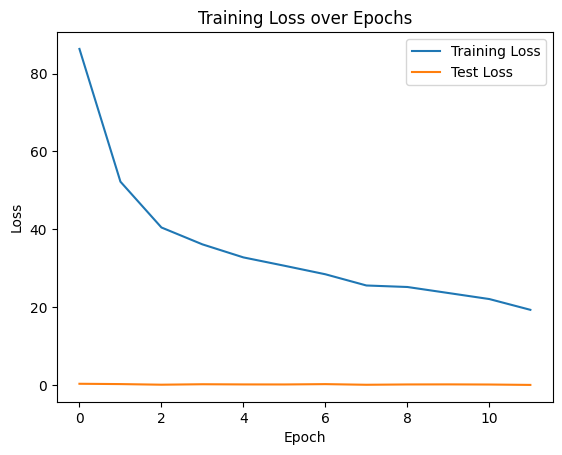

In [48]:
plt.plot(tr_losses, label='Training Loss')
plt.plot(accuracies, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

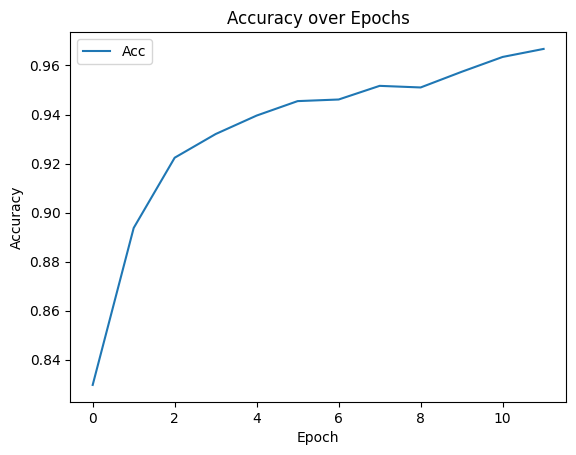

In [49]:
plt.plot(accuracies, label='Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()